In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tweepy
from datetime import datetime
import pandas as pd
import json
import sys
from decimal import Decimal
# sys.path.append("../")
import numpy as np
import os
consumer_key=os.environ.get('consumer_key')
consumer_secret=os.environ.get('consumer_secret')
access_token=os.environ.get('access_token')
access_token_secret=os.environ.get('access_token_secret')
# from config import (consumer_key, 
#                     consumer_secret, 
#                     access_token, 
#                     access_token_secret)

In [2]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [4]:
# Target Search Term

target_names = ["@BBC","@CBS","@CNN","@FoxNews","@nytimes"]
sentiment_elements=["neg",'neu','pos','compound',"created_at",'text']
index2=pd.MultiIndex.from_product([[str(i) for i in range(100)], target_names],names=['#', 'Source'])

tweet_df=pd.DataFrame(columns=sentiment_elements,index=index2)

for name in target_names:
        public_tweets = api.user_timeline(screen_name=name,count=100,tweet_mode='extended')
        i_th=-1
        for tweet in public_tweets:
        # Run Vader Analysis on each tweet
            i_th+=1 
            result= analyzer.polarity_scores(tweet["full_text"])
            tweet_df.loc[(str(i_th),name),"compound"]=result["compound"]
            tweet_df.loc[(str(i_th),name),"pos"]=result["pos"]
            tweet_df.loc[(str(i_th),name),"neu"]=result["neu"]
            tweet_df.loc[(str(i_th),name),"neg"]=result["neg"]
            tweet_df.loc[(str(i_th),name),"created_at"]=datetime.strptime(tweet['created_at'], "%a %b %d %H:%M:%S %z %Y")
            tweet_df.loc[(str(i_th),name),"text"]=tweet["full_text"]
    
tweet_df['Tweets ago']=tweet_df.index.get_level_values(0)
tweet_df['Tweets ago']=pd.to_numeric(tweet_df['Tweets ago']);
tweet_df['compound']=pd.to_numeric(tweet_df['compound']);
tweet_df.head()
tweet_df=tweet_df.reset_index(level=[0,1])
tweet_df.head()


neg    neu    pos  compound                 created_at  \
# Source                                                               
0 @BBC          0      1      0    0.0000  2019-03-16 16:01:06+00:00   
  @CBS      0.102  0.856  0.041   -0.2960  2019-03-16 16:00:00+00:00   
  @CNN      0.091  0.909      0   -0.6597  2019-03-16 16:44:00+00:00   
  @FoxNews      0      1      0    0.0000  2018-11-08 19:18:44+00:00   
  @nytimes      0  0.863  0.137    0.4019  2019-03-16 16:40:14+00:00   

                                                         text  Tweets ago  
# Source                                                                   
0 @BBC      For some of these children, it was the first t...           0  
  @CBS      Tonight, “One Night for One Drop: Imagined by ...           0  
  @CNN      “What we saw … was evil unleashed on paradise,...           0  
  @FoxNews  BREAKING: Federal appeals court rules against ...           0  
  @nytimes  This baked pasta recipe features parmesan and ...           0

,#,Source,neg,neu,pos,compound,created_at,text,Tweets ago
0,0,@BBC,0,1,0,0.0000,2019-03-16 16:01:06+00:00,"For some of these children, it was the first t...",0
1,0,@CBS,0.102,0.856,0.041,-0.2960,2019-03-16 16:00:00+00:00,"Tonight, “One Night for One Drop: Imagined by ...",0
2,0,@CNN,0.091,0.909,0,-0.6597,2019-03-16 16:44:00+00:00,"“What we saw … was evil unleashed on paradise,...",0
3,0,@FoxNews,0,1,0,0.0000,2018-11-08 19:18:44+00:00,BREAKING: Federal appeals court rules against ...,0
4,0,@nytimes,0,0.863,0.137,0.4019,2019-03-16 16:40:14+00:00,This baked pasta recipe features parmesan and ...,0


In [5]:
##transform the sentiments into a pivotal table
tweet_df=tweet_df.sort_values(by="created_at")
seniment_data=tweet_df[["Source","compound","Tweets ago"]].pivot(index="Tweets ago",columns="Source",values="compound");

## The first plot

<IPython.core.display.Javascript object>


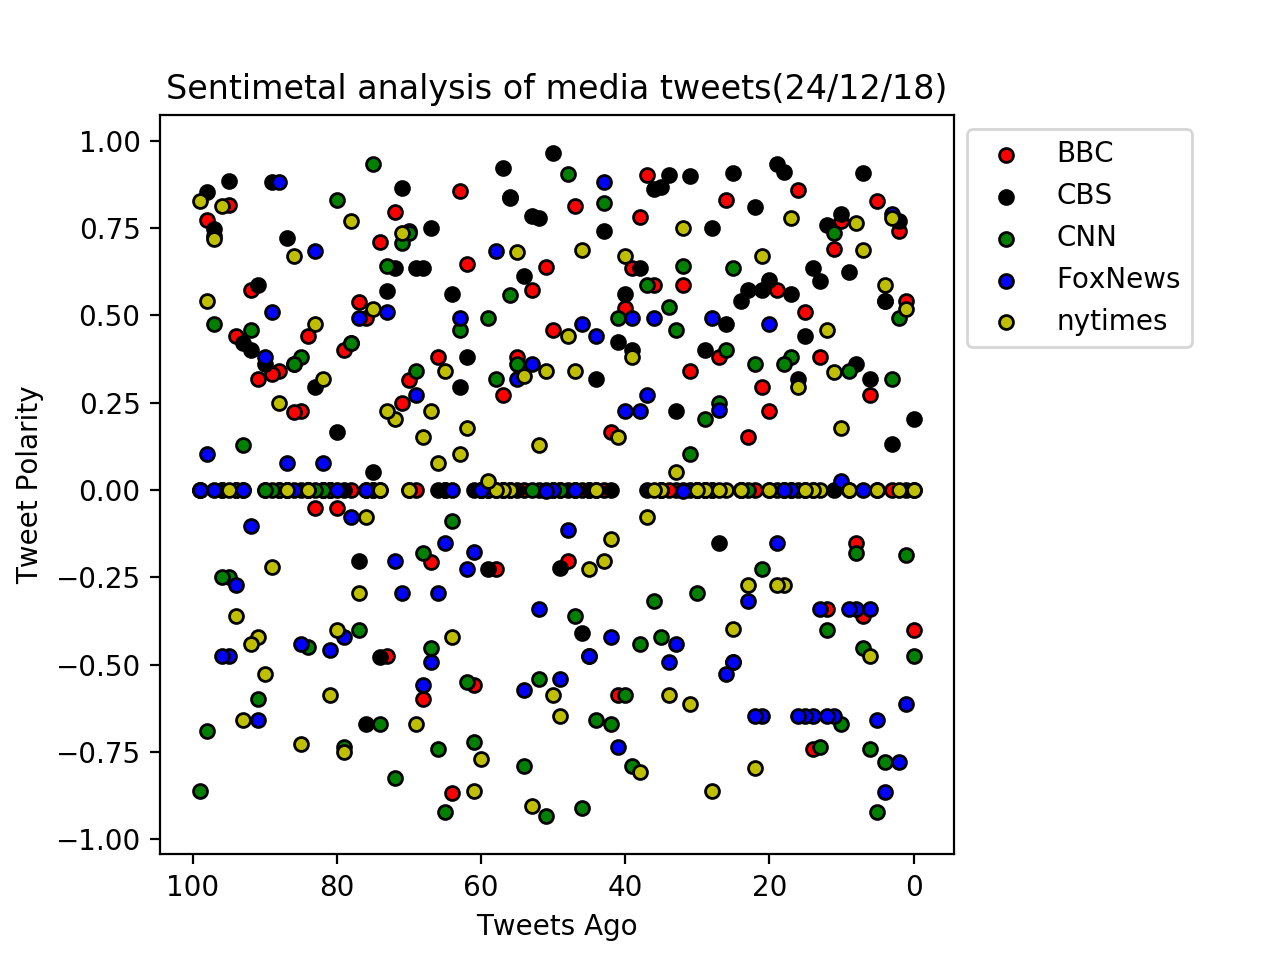

In [6]:
fig1, ax1 = plt.subplots()
x_axis=seniment_data.reset_index()["Tweets ago"].values

s1=ax1.scatter(x_axis, seniment_data["@BBC"].values,marker='.',c='r',label="BBC",edgecolors='k',s=100);
s2=ax1.scatter(x_axis, seniment_data["@CBS"].values,marker='.',c='k',label="CBS",edgecolors='k',s=100);
s3=ax1.scatter(x_axis, seniment_data["@CNN"].values,marker='.',c='g',label="CNN",edgecolors='k',s=100);
s4=ax1.scatter(x_axis, seniment_data["@FoxNews"].values,marker='.',c='b',label="FoxNews",edgecolors='k',s=100);
s5=ax1.scatter(x_axis, seniment_data["@nytimes"].values,marker='.',c='y',label="nytimes",edgecolors='k',s=100);


#https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
# Shrink current axis by 20%
box = ax1.get_position()
pos=ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
leg=ax1.legend(loc='upper left', bbox_to_anchor=(1, 1.0))
plt.gca().invert_xaxis()

from datetime import date
title=ax1.set_title(f"Sentimetal analysis of media tweets({date.today().strftime('%d/%m/%y')})");
xlabel=ax1.set_xlabel("Tweets Ago")
ylabel=ax1.set_ylabel("Tweet Polarity")
plt.savefig('Sentimetal_data_of_media_tweets.png')


##  The second plot 

<IPython.core.display.Javascript object>


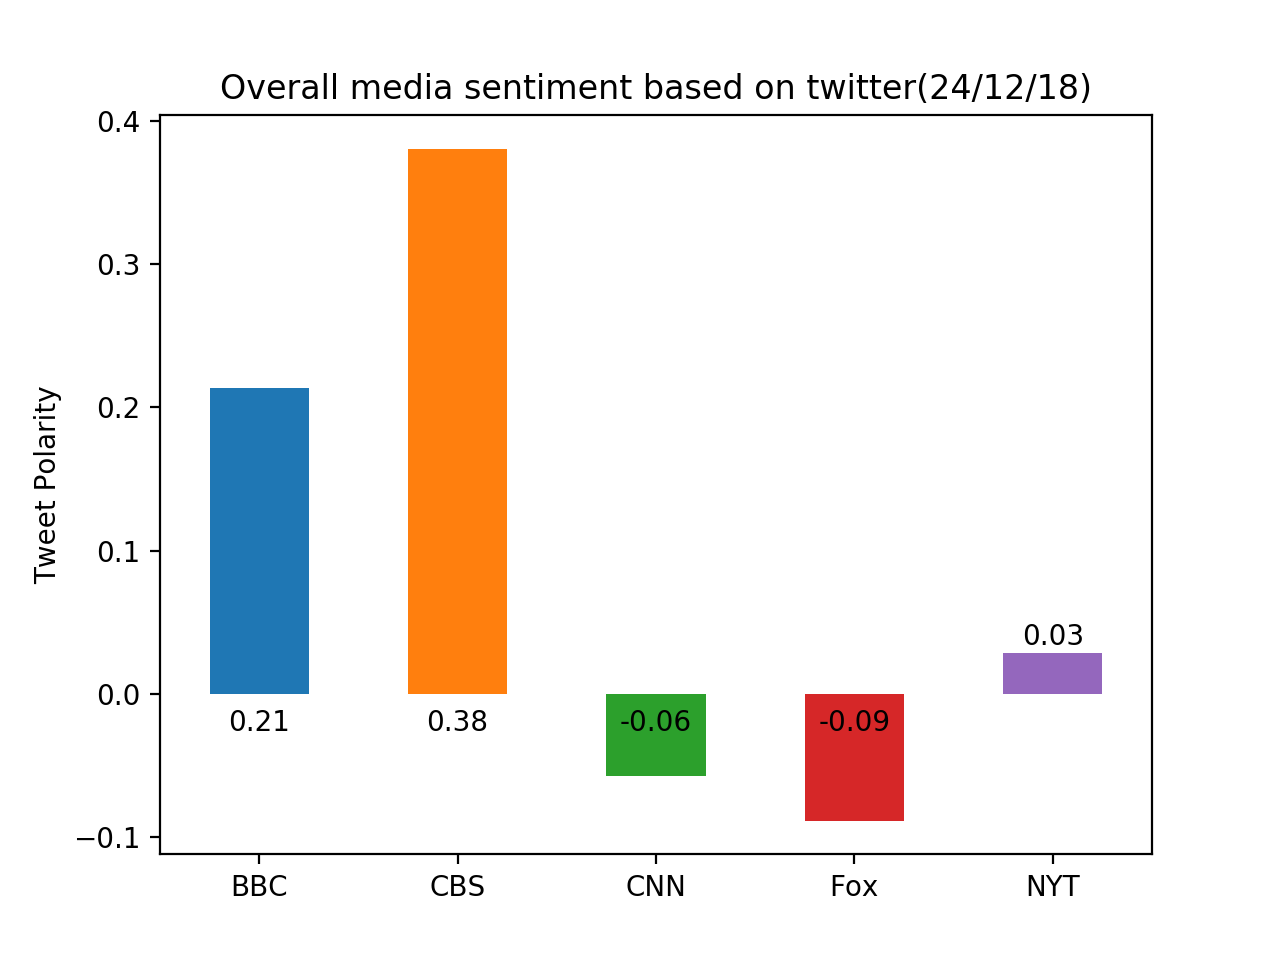

In [7]:
fig2, ax2 = plt.subplots()
bar=seniment_data.mean().plot(kind='bar',ax=ax2,rot=0)
xtick_label=ax2.set_xticklabels(["BBC","CBS","CNN","Fox","NYT"])
xlabel=ax2.set_xlabel("")
ylabel=ax2.set_ylabel("Tweet Polarity")
title=ax2.set_title(f"Overall media sentiment based on twitter({date.today().strftime('%d/%m/%y')})")

def labelbar(x,y,t):
    txt=ax2.text(x, y,t,ha='center', va='bottom')

x=ax2.get_xticks()
y=4*[-0.03]+[0.03]
t = [round(Decimal(seniment_data.mean().values[i]),2) for i in range(len(x))]

for i in range(len(x)):
    labelbar(x[i],y[i],str(t[i]))
# Save the Figure
plt.savefig('Overall_media_sentiment.png')


## save DataFrame  to csv

In [130]:
seniment_data.to_csv("sentiment_data.csv")
tweet_df.to_csv("full_sentiment_data.csv")

In [ ]:
# ## Observations:
# > -  the twittering frequency of CBS is the lowest among the 5 organzations. If we take most recent 100 tweets, the timestamp goes back to early August. For BBC, it goes back to 2018-09-25. For CNN, FoxNews and NewYorkTimes, about half an day ago.
# -  For the past 100 tweets, NewYorkTimes is the only one that has overall negative mood.
# -  The sentiment of each organization fluctuates greatly. A great portion of tweets for all organizations are neutral.  
# -  During the past 2 months, CBS changes from very positive to positive.
# - During the past week, BBS changes its mood from  positive to weakly positive.


In [121]:
tweet_df[tweet_df["Source"]=="@nytimes"]

,#,Source,neg,neu,pos,compound,created_at,text,Tweets ago
499,99,@nytimes,0,0.902,0.098,0.3400,2018-10-01 21:39:45+00:00,"You’ve somehow coughed up the first, last and ...",99
494,98,@nytimes,0,0.919,0.081,0.3182,2018-10-01 21:46:39+00:00,Classic roast chicken. Not-from-a-box macaroni...,98
489,97,@nytimes,0.069,0.806,0.125,0.3506,2018-10-01 21:51:39+00:00,Her Tinder date lied to her. But she felt like...,97
484,96,@nytimes,0.107,0.73,0.163,0.0772,2018-10-01 21:53:36+00:00,Do you have student loan debt? Our writer shar...,96
479,95,@nytimes,0,0.806,0.194,0.5859,2018-10-01 21:56:03+00:00,Navigating your first job out of college is a ...,95
474,94,@nytimes,0,1,0,0.0000,2018-10-01 21:59:07+00:00,How is a 401(k) different from a Roth IRA? We'...,94
469,93,@nytimes,0.066,0.934,0,-0.0516,2018-10-01 22:01:30+00:00,Pay yourself first. Be a coupon clipper. Savin...,93
464,92,@nytimes,0.104,0.744,0.152,0.1280,2018-10-01 22:05:09+00:00,He was miserable working at a law firm. So he ...,92
459,91,@nytimes,0.127,0.873,0,-0.1901,2018-10-01 22:06:42+00:00,Everyone makes mistakes. But we can recover — ...,91
454,90,@nytimes,0,1,0,0.0000,2018-10-01 22:17:04+00:00,The new trade pact has something for everyone:...,90
